## Yield curve prediction

The goal of this case study is to use supervised learning-based models to predict the yield
curve. This case study is inspired by the paper “_Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting_” by Nunes, Gerding, McGroarty and Niranj

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Corporate Spread on Baa rated Debt Relative to the 10 Year

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Feature Variables

In [1]:
import os
import sys


root_dir = os.path.abspath('../..')
sys.path.append(root_dir)
from functions import ParamsKfold, ParamsGridSearch, run_grid_search, run_kfold_analysis, calc_best_features
from case_study_4 import load_data, clean_data


In [2]:
# Core libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import chi2, f_regression, SelectKBest

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


2022-10-06 08:53:49.205104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 08:53:49.205270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='1.2'></a>
## 2.2. Loading the Data

In [4]:
# Get the data by webscapping using pandas datareader

tsy_tickers = [
    'DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
    'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
    'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
tsy_data = load_data(tsy_tickers)


In [5]:
return_period = 5
X, Y = clean_data(tsy_data, return_period)
dataset = pd.concat([X, Y], axis=1)

In [6]:
dataset.head(2)

,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y,DGS1MO_pred,DGS5_pred,DGS30_pred
DATE,,,,,,,,,,,,,,,
2018-01-01,1.28,1.39,1.76,1.89,2.20,2.33,2.40,2.74,0.116371,0.73196,0.295093,1.77,1.30,2.29,2.81
2018-01-08,1.30,1.45,1.79,1.96,2.29,2.41,2.49,2.81,0.116086,0.73196,0.295093,1.74,1.33,2.36,2.83


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [7]:
dataset.shape


(240, 15)

In [8]:
pd.set_option('precision', 3)
dataset.describe()


,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y,DGS1MO_pred,DGS5_pred,DGS30_pred
count,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000,240.000
mean,1.076,1.161,1.367,1.480,1.703,1.860,1.974,2.408,0.142,0.760,0.275,2.182,1.083,1.710,2.412
std,0.968,1.003,1.103,1.107,0.991,0.908,0.831,0.639,0.038,0.023,0.021,0.406,0.975,1.001,0.645
min,0.000,0.000,0.040,0.110,0.190,0.360,0.520,1.170,0.091,0.731,0.243,1.590,0.000,0.190,1.170
25%,0.080,0.090,0.138,0.210,0.798,1.120,1.360,1.927,0.103,0.736,0.255,1.910,0.080,0.798,1.927
50%,1.290,1.450,1.580,1.585,1.655,1.740,1.815,2.310,0.153,0.776,0.266,2.130,1.315,1.655,2.310
75%,1.995,2.062,2.333,2.500,2.672,2.772,2.810,3.020,0.183,0.783,0.295,2.292,2.010,2.683,3.022
max,2.730,3.390,4.170,4.270,4.150,4.060,3.880,3.720,0.191,0.786,0.305,4.040,2.870,4.150,3.730


<a id='2.2'></a>
## 3.2. Data Visualization

<AxesSubplot:xlabel='DATE'>

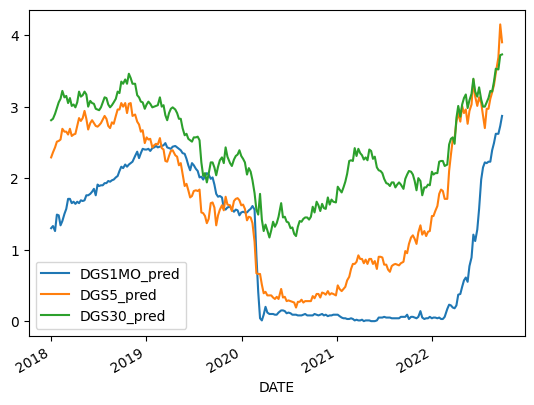

In [9]:
Y.plot()


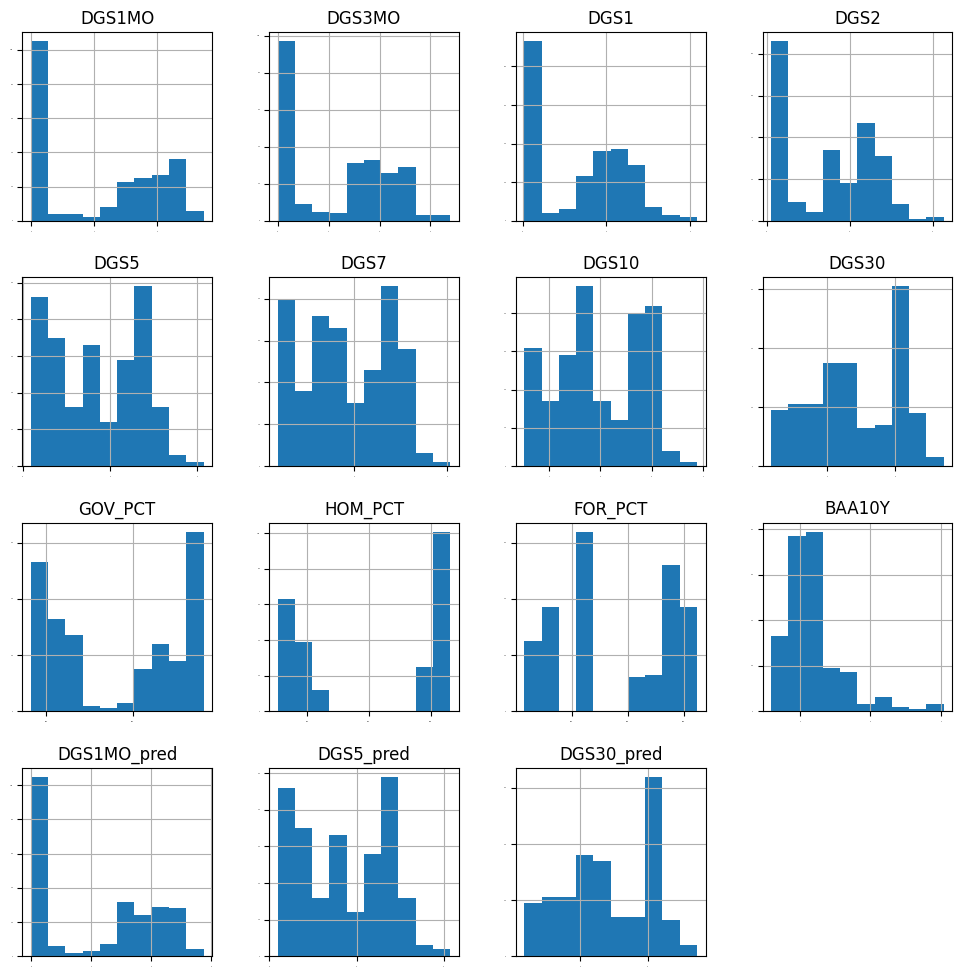

In [10]:
# Histograms

dataset.hist(
    sharex=False, 
    sharey=False, 
    xlabelsize=1, 
    ylabelsize=1, 
    figsize=(12, 12)
)
pyplot.show()


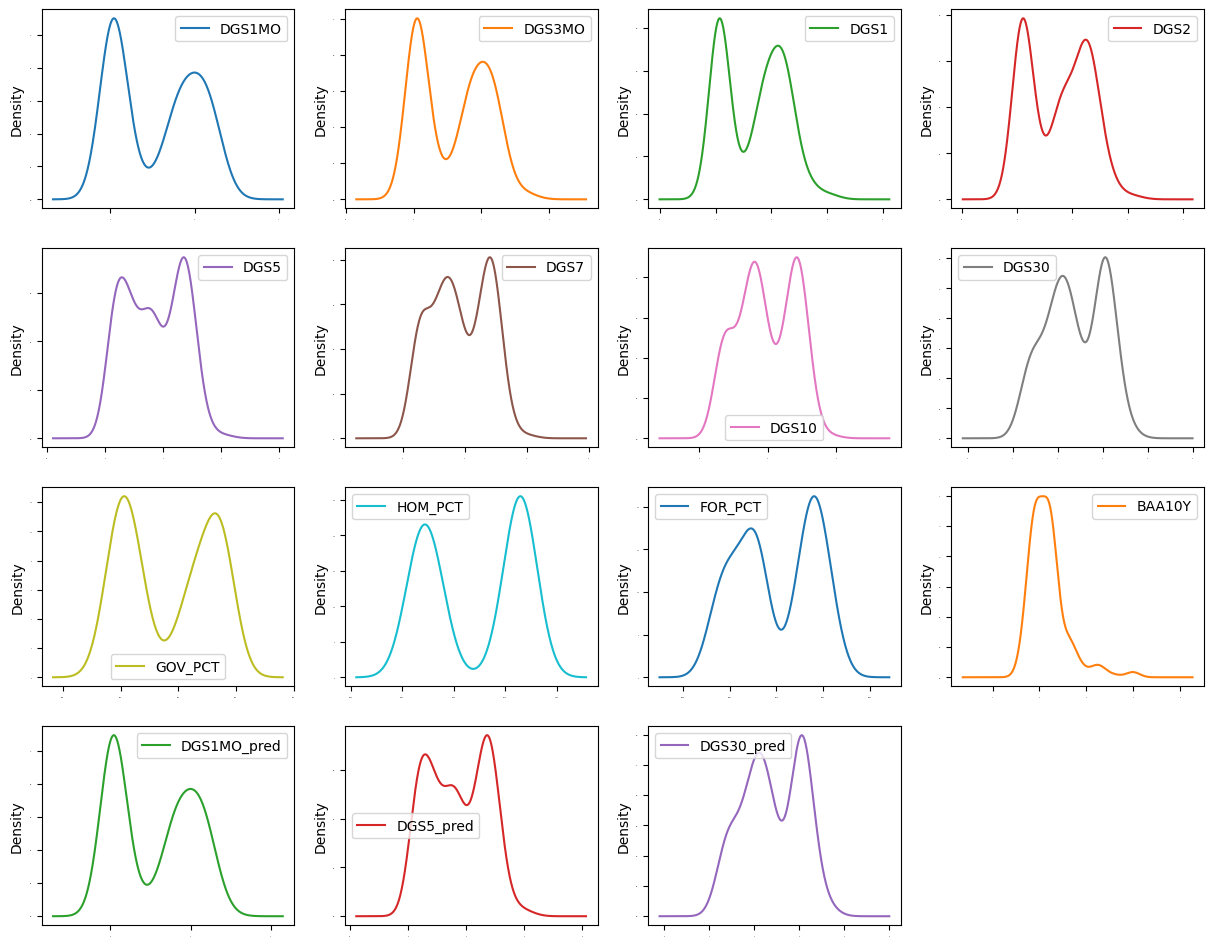

In [11]:
# Density

dataset.plot(
    kind='density', 
    subplots=True, 
    layout=(5, 4), 
    sharex=False, 
    legend=True, 
    fontsize=1, 
    figsize=(15, 15)
)
pyplot.show()


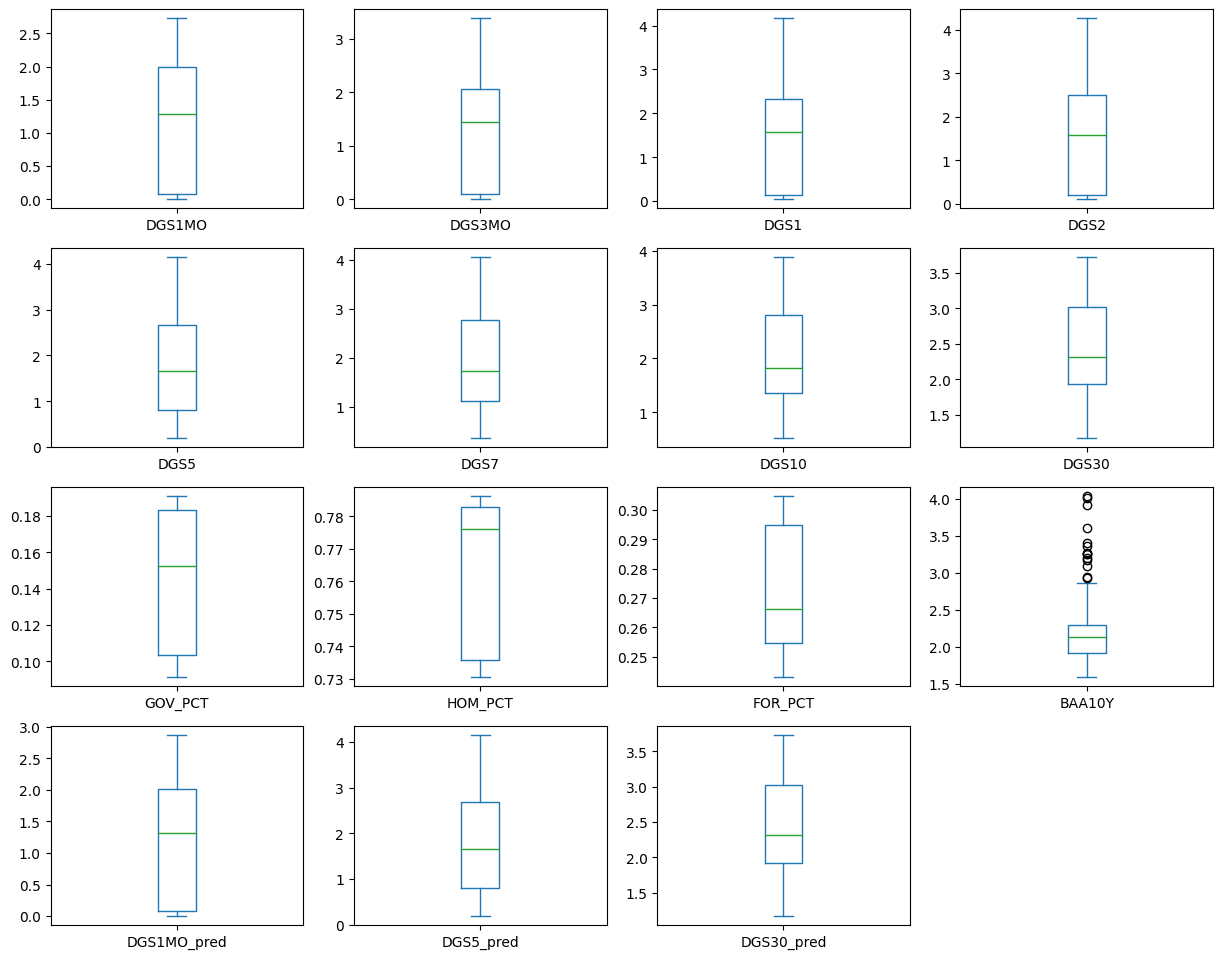

In [12]:
# Box and Whisker Plots

dataset.plot(
    kind='box', 
    subplots=True, 
    layout=(5, 4), 
    sharex=False, 
    sharey=False, 
    figsize=(15, 15)
)
pyplot.show()


Next We look at the interaction between these variables.

<AxesSubplot:title={'center':'Correlation Matrix'}>

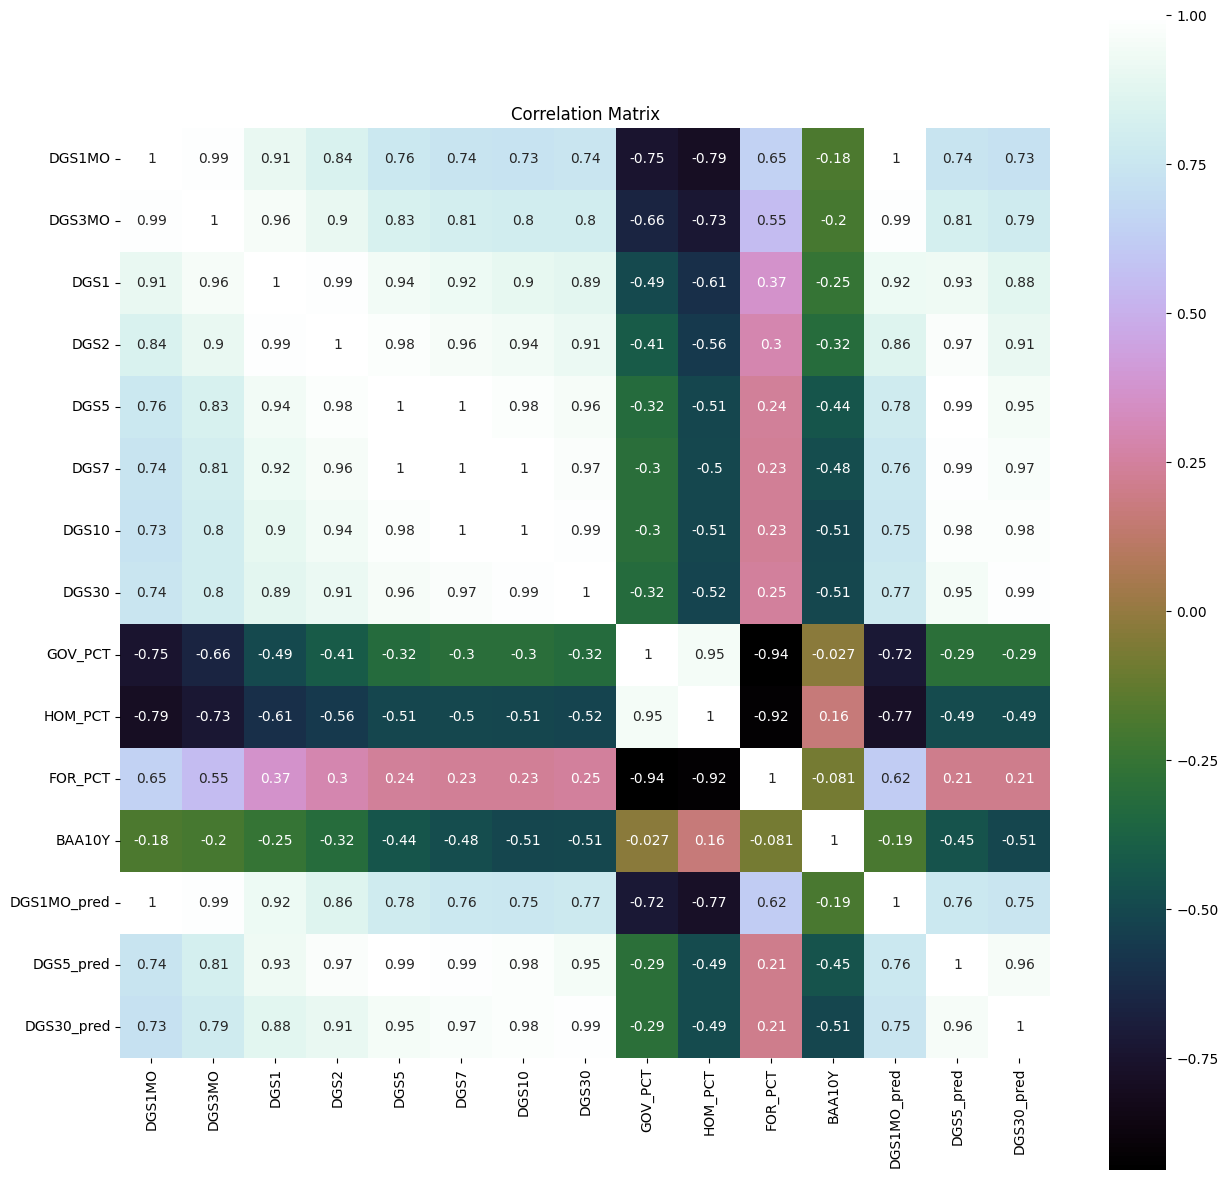

In [13]:
# Correlation

correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')


Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

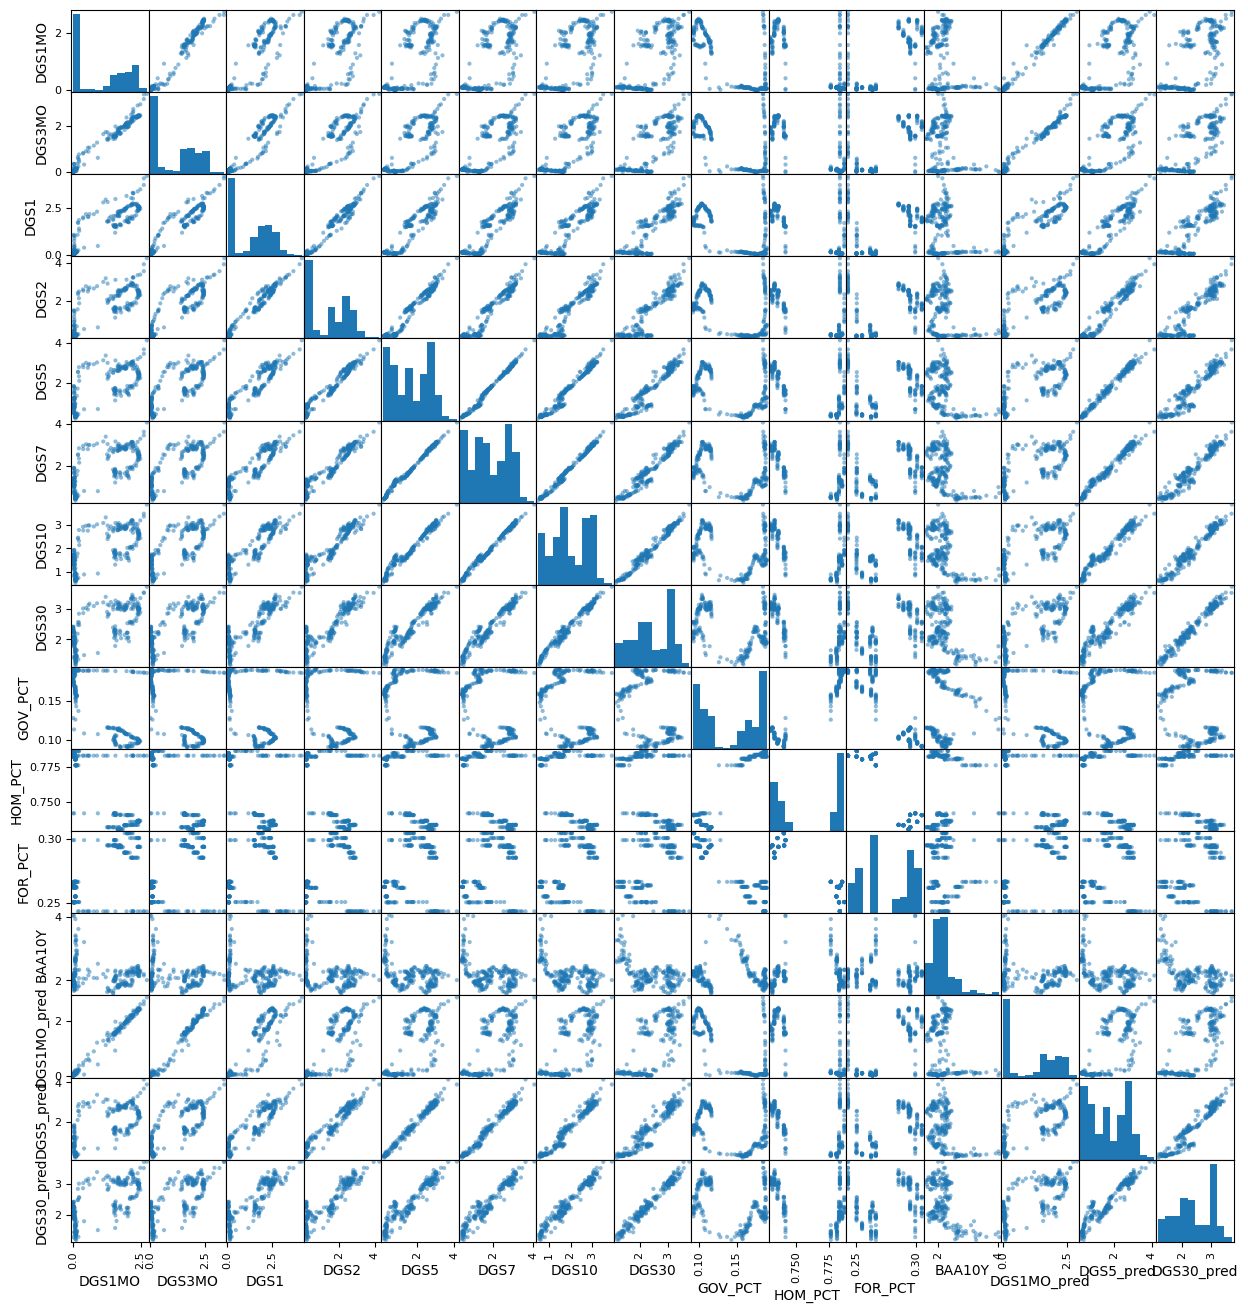

In [14]:
# Scatterplot Matrix

pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(15, 16))
pyplot.show()


<a id='2.3'></a>
## 3.3. Time Series Analysis

#### 1 Month

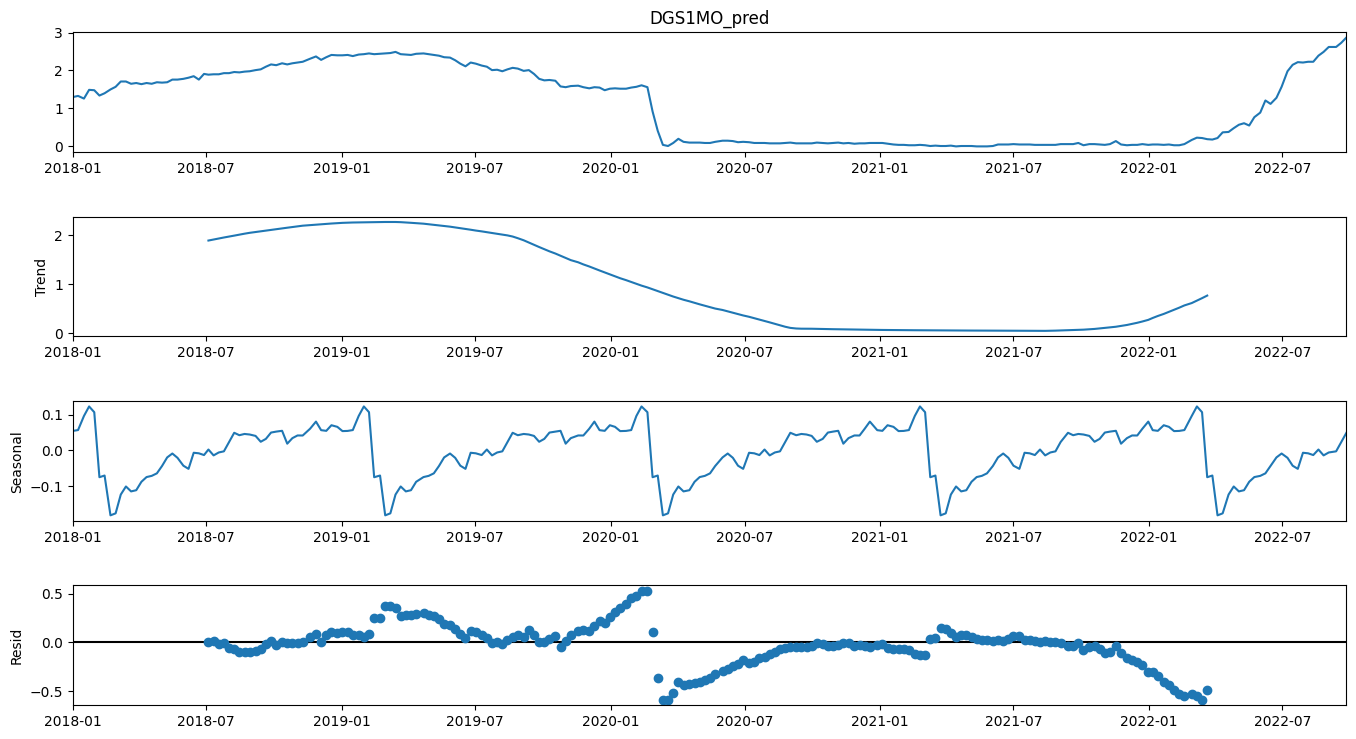

In [15]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


#### 5 Year

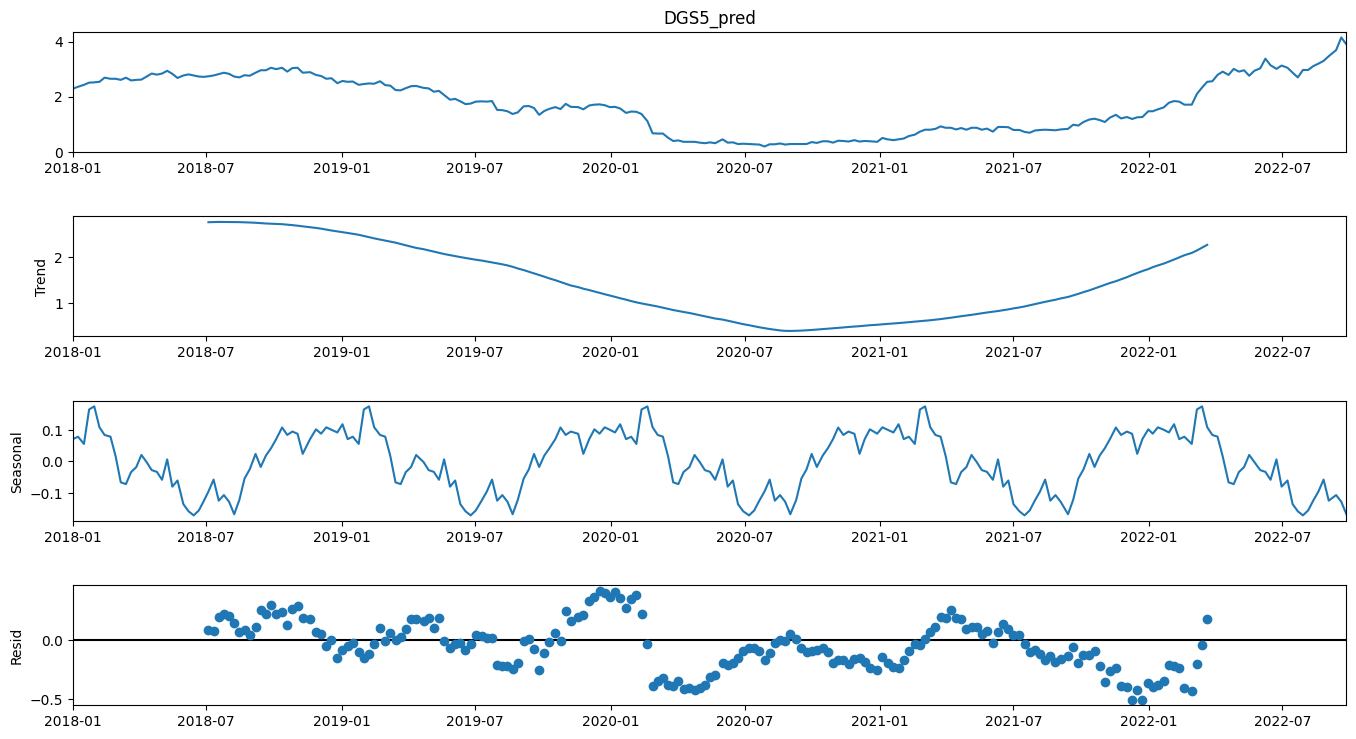

In [16]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


#### 30 Year

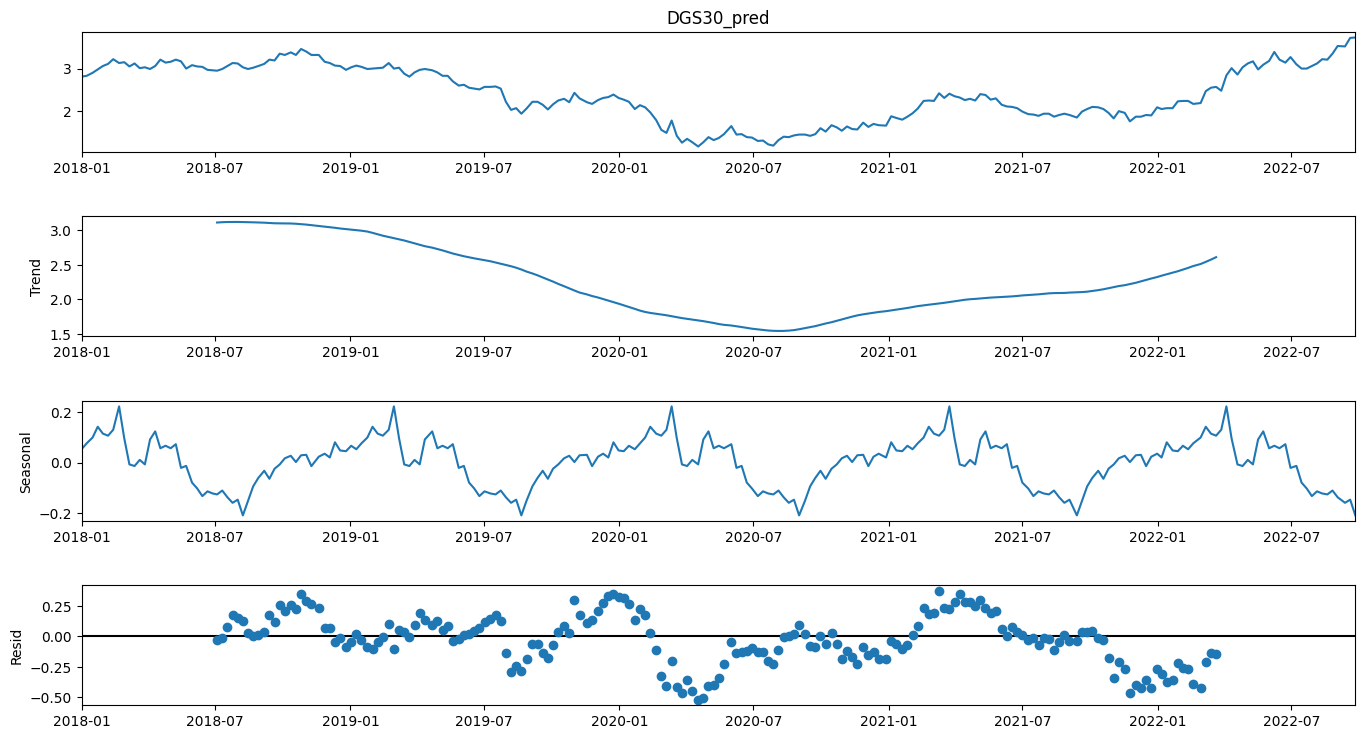

In [17]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

<a id='3'></a>
## 4. Data Preparation and analysis

<a id='3.1'></a>
## 4.1. Univariate Feature Selection

In [18]:
calc_best_features(X, Y)

----------------------------------------------------------------
             Score
Specs             
DGS1MO   29323.496
DGS3MO   13877.126
DGS1      1370.149
DGS2       654.238
DGS5       374.378
HOM_PCT    354.608
DGS30      337.631
DGS7       326.228
DGS10      314.861
GOV_PCT    256.801
----------------------------------------------------------------
             Score
Specs             
DGS5     19718.750
DGS7     11514.994
DGS10     5280.360
DGS2      3874.556
DGS30     2140.218
DGS1      1501.068
DGS3MO     466.352
DGS1MO     289.361
HOM_PCT     73.609
BAA10Y      60.070
----------------------------------------------------------------
            Score
Specs            
DGS30    9157.976
DGS10    5879.150
DGS7     3460.288
DGS5     2251.230
DGS2     1110.879
DGS1      802.751
DGS3MO    385.363
DGS1MO    263.903
BAA10Y     84.167
HOM_PCT    74.459


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and evaluation metrics

In [19]:
# Split out validation dataset for the end

validation_size = 0.2

# In this case the data is not dependent on the time series, 
# so we can split the training and testing data randomly
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)


We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as follows

In [20]:
# Test options for regression

num_folds = 10
scoring = 'neg_mean_squared_error'


<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

In [21]:
models = [
    # Linear models
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    
    # Neural Network model
    ('MLP', MLPRegressor()),
]

In [22]:
params_kfold_search = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
)
kfold_results = run_kfold_analysis(params_kfold_search)


LR: 0.009409 (0.002917) 0.007530 0.012013
LASSO: 0.742032 (0.127052) 0.730590 0.648525
EN: 0.323894 (0.049386) 0.318333 0.298258
KNN: 0.013220 (0.005759) 0.007933 0.019039
CART: 0.031483 (0.023811) 0.000000 0.029105
MLP: 0.089733 (0.065880) 0.012179 0.015105


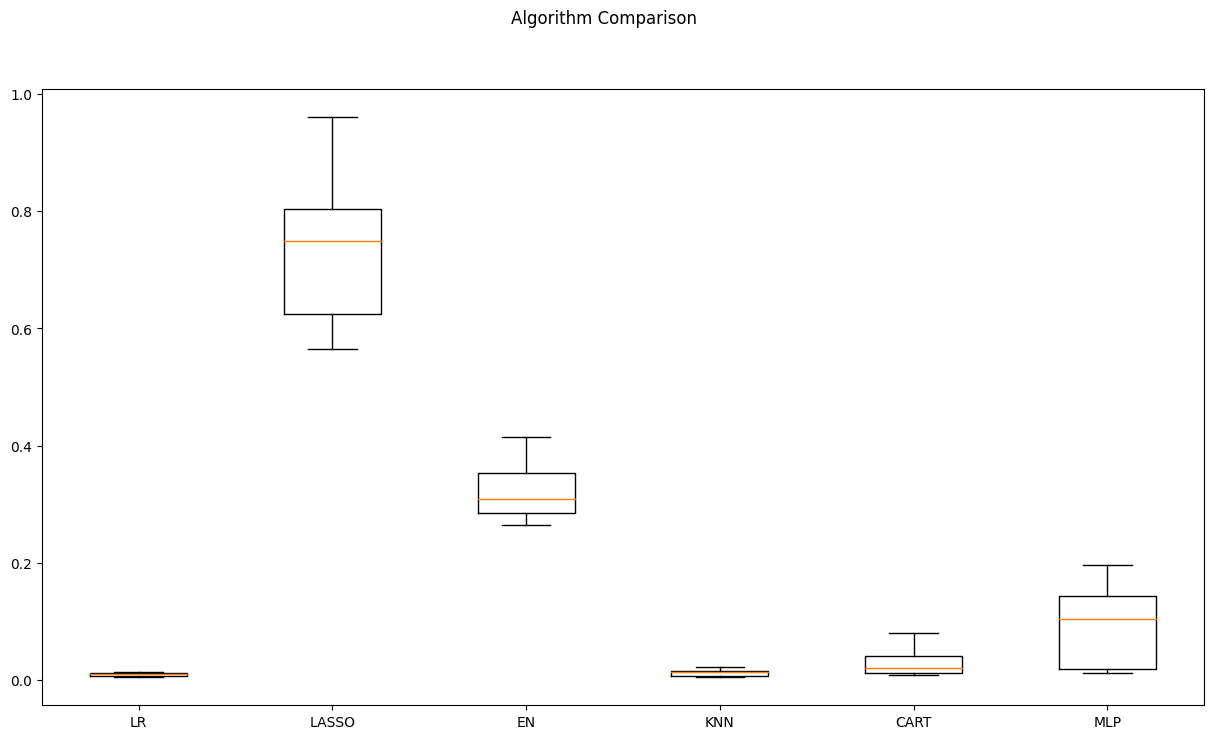

In [23]:
# Compare algorithms

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results.kfold_results)
ax.set_xticklabels(kfold_results.names)
fig.set_size_inches(15, 8)
pyplot.show()


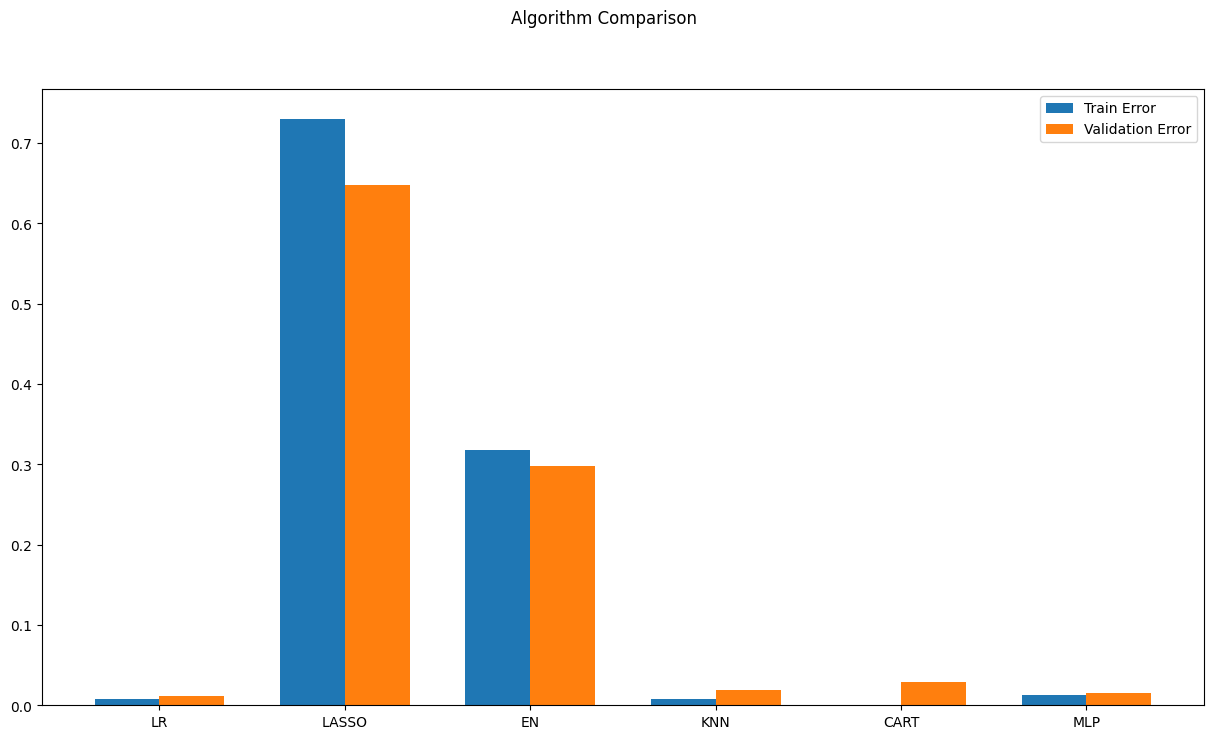

In [24]:
# Compare algorithms again

fig = pyplot.figure()

ind = np.arange(len(kfold_results.names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - (width / 2), [x.mean() for x in kfold_results.train_results],  width=width, label='Train Error')
pyplot.bar(ind + (width / 2), [x.mean() for x in kfold_results.test_results], width=width, label='Validation Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(kfold_results.names)
pyplot.show()


<a id='5'></a>
# 6. Model Tuning and Grid Search

In [25]:
params_search = ParamsGridSearch(
    model=MLPRegressor(),
    params_grid={'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]},
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
    shuffle=True,

)
search_results = run_grid_search(params_search)
layer_sizes = search_results.best_params_['hidden_layer_sizes']


Best: -0.050003 using {'hidden_layer_sizes': (20, 30, 20)}
-0.093638 (0.099499) with: {'hidden_layer_sizes': (20,)}
-0.050805 (0.046394) with: {'hidden_layer_sizes': (50,)}
-0.072313 (0.078688) with: {'hidden_layer_sizes': (20, 20)}
-0.050003 (0.053987) with: {'hidden_layer_sizes': (20, 30, 20)}


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results and comparison of Regression and MLP

In [26]:
# MLP model

model = MLPRegressor(hidden_layer_sizes=layer_sizes)
model.fit(X_train, Y_train)

# Estimate accuracy on validation set

Y_test_predict = model.predict(X_test)
mse_MLP = mean_squared_error(Y_test, Y_test_predict)
r2_MLP = r2_score(Y_test, Y_test_predict)
print(f"MSE MLP = {mse_MLP:.6f}, R2 MLP = {r2_MLP:.6f}")


MSE MLP = 0.030329, R2 MLP = 0.957179


In [27]:
# Regression model

model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
Y_test_predict = model_2.predict(X_test)

# Estimate accuracy on validation set

mse_OLS = mean_squared_error(Y_test, Y_test_predict)
r2_OLS = r2_score(Y_test, Y_test_predict)
print(f"MSE Regression = {mse_OLS:.6f}, R2 Regression = {r2_OLS:.6f}")


MSE Regression = 0.012013, R2 Regression = 0.979714


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [28]:
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=layer_sizes)
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)
Y_predMLP = pd.DataFrame(
    model_MLP.predict(X_test), 
    index=Y_test.index,
    columns=Y_test.columns
)
Y_predOLS = pd.DataFrame(
    model_OLS.predict(X_test), 
    index=Y_test.index,
    columns=Y_test.columns
)


Plot predictions


<AxesSubplot:xlabel='DATE'>

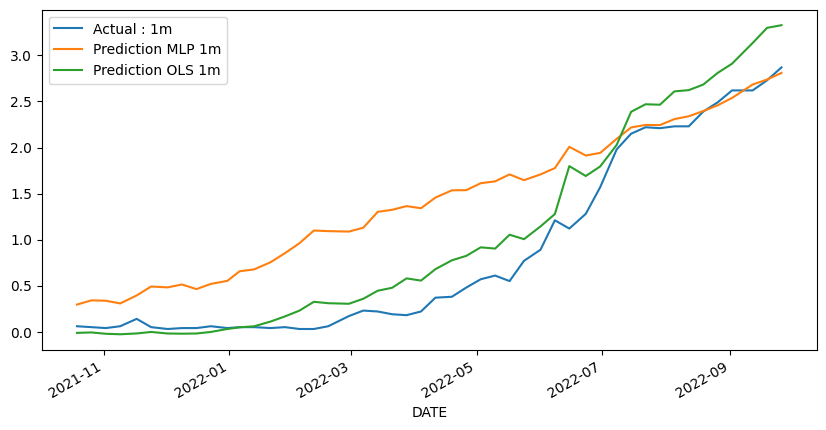

In [29]:
df = pd.DataFrame({
    'Actual : 1m': Y_test.loc[:, 'DGS1MO_pred'],
    'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
    'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']
})
df.plot(figsize=(10, 5))


<AxesSubplot:xlabel='DATE'>

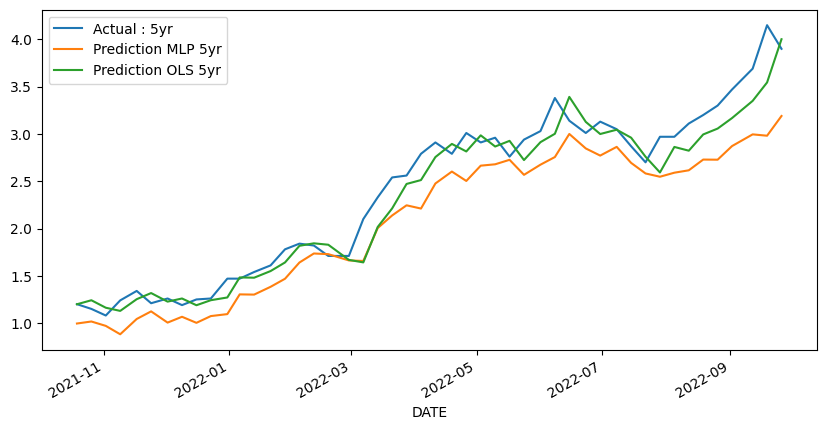

In [30]:
df = pd.DataFrame({
    'Actual : 5yr': Y_test.loc[:, 'DGS5_pred'],
    'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
    'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']
})
df.plot(figsize=(10, 5))


<AxesSubplot:xlabel='DATE'>

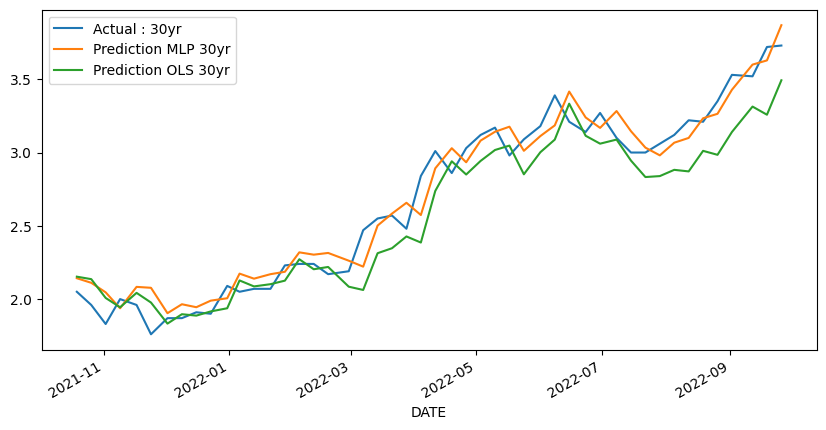

In [31]:
df = pd.DataFrame({
    'Actual : 30yr': Y_test.loc[:, 'DGS30_pred'],
    'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
    'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']
})
df.plot(figsize=(10, 5))


Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.